### Setup
Change working directory to avoid path error.

In [2]:
import os
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-vlm-lpb25/"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/thuang/Documents/Personal/code/microscopy-vlm-lpb25


### Prepare Metadata

In [5]:
import glob
import pandas as pd

DATA_ROOT_PATH = "data/marco"
image_list = glob.glob(os.path.join(DATA_ROOT_PATH, "**", "*.jpeg"), recursive=True)
print(len(image_list))
print(image_list[:5])

79
['data/marco/gsk/other/1254.jpeg', 'data/marco/gsk/other/1782.jpeg', 'data/marco/gsk/other/1848.jpeg', 'data/marco/gsk/other/1783.jpeg', 'data/marco/gsk/other/1209.jpeg']


In [8]:
gt_labels = [image_directory.split("/")[-2] for image_directory in image_list]
print(gt_labels[:5])
sources = [image_directory.split("/")[-3] for image_directory in image_list]
print(sources[:5])
tags = ["test"] * len(image_list)
print(tags[:5])

['other', 'other', 'other', 'other', 'other']
['gsk', 'gsk', 'gsk', 'gsk', 'gsk']
['test', 'test', 'test', 'test', 'test']


In [10]:
meta_df = pd.DataFrame({
    "image_dir": image_list,
    "label": gt_labels,
    "source": sources,
    "tag": tags
})
print(len(meta_df))
meta_df.describe()

79


,image_dir,label,source,tag
count,79,79,79,79
unique,79,4,1,1
top,data/marco/gsk/other/1254.jpeg,other,gsk,test
freq,1,20,79,79


In [12]:
row1 = {"image_dir": "data/marco/gsk/clear/220.jpeg", "label": "clear", "source": "gsk", "tag": "prompt"}
row2 = {"image_dir": "data/marco/gsk/crystals/6488.jpeg", "label": "crystals", "source": "gsk", "tag": "prompt"}
row3 = {"image_dir": "data/marco/gsk/other/9123.jpeg", "label": "other", "source": "gsk", "tag": "prompt"}
row4 = {"image_dir": "data/marco/gsk/precipitate/200.jpeg", "label": "precipitate", "source": "gsk", "tag": "prompt"}
meta_df_append = pd.DataFrame([row1, row2, row3, row4])
meta_df = pd.concat([meta_df, meta_df_append], ignore_index=True)
print(len(meta_df))
meta_df.describe()

83


,image_dir,label,source,tag
count,83,83,83,83
unique,83,4,1,2
top,data/marco/gsk/other/1254.jpeg,other,gsk,test
freq,1,21,83,79


In [13]:
meta_df.head()

,image_dir,label,source,tag
0,data/marco/gsk/other/1254.jpeg,other,gsk,test
1,data/marco/gsk/other/1782.jpeg,other,gsk,test
2,data/marco/gsk/other/1848.jpeg,other,gsk,test
3,data/marco/gsk/other/1783.jpeg,other,gsk,test
4,data/marco/gsk/other/1209.jpeg,other,gsk,test


In [ ]:
# meta_df.to_csv("data/marco/metadata/metadata_v0.csv", index=False)

### Prompt with structured output

In [15]:
from mwm_vlm.utils.common import encode_image

def get_prpmpt(image_path):

    # Base64 encode each example image and your test image
    base64_example1 = encode_image("data/marco/gsk/crystals/6488.jpeg")
    base64_example2 = encode_image("data/marco/gsk/clear/220.jpeg")
    base64_example3 = encode_image("data/marco/gsk/precipitate/200.jpeg")
    base64_example4 = encode_image("data/marco/gsk/other/9123.jpeg")
    base64_test = encode_image(image_path)

    # Prepare the common part of the prompt
    instructions = (
        "You are helping with tagging Protein Crystallization images. "
        "You will be given an image and a list of labels with definitions. "
        "Choose the most appropriate single label from the list according to the definition. "
        "Add a short explanation of your choice at the end in free text.\n\n"
        "**List:**\n"
        "[clear, crystals, precipitate, other]\n\n"
        "**Definitions:**\n"
        "clear: Transparent solution without any particulate matter observed within a droplet or in the field of view.\n"
        "crystals: Crystals observed within a droplet or in the field of view.\n"
        "precipitate: Precipitate observed within a droplet or in the field of view.\n"
        "other: Unexpected observations which are not clear solution, crystals, or precipitate.\n\n"
        "Below are some examples:\n"
    )

    # Build the list of input items
    input_items = [
        {"type": "input_text", "text": instructions},

        # Example 1
        {"type": "input_text", "text": "**Example 1:**"},
        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{base64_example1}"},
        {"type": "input_text", "text": "Label: crystals\nExplanation: Distinct crystal structures can be seen forming in the droplet."},

        # Example 2
        {"type": "input_text", "text": "**Example 2:**"},
        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{base64_example2}"},
        {"type": "input_text", "text": "Label: clear\nExplanation: The droplet is transparent and shows no visible particles or structures."},

        # Example 3
        {"type": "input_text", "text": "**Example 3:**"},
        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{base64_example3}"},
        {"type": "input_text", "text": "Label: precipitate\nExplanation: Granular particles are scattered across the droplet indicating precipitation."},

        # Example 4
        {"type": "input_text", "text": "**Example 4:**"},
        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{base64_example4}"},
        {"type": "input_text", "text": "Label: other\nExplanation: The image shows unexpected structures which are not clear solution, crystals, or precipitate."},

        # Now the actual test image
        {"type": "input_text", "text": "**Now classify the following image:**"},
        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{base64_test}"},
    ]

    return input_items

In [ ]:
import json
from openai import OpenAI

OPENAI_API_KEY = ""
CLIENT = OpenAI(api_key=OPENAI_API_KEY)
OUTPUT_SCHEMA = json.load(open("src/mwm_vlm/components/output_schema.json"))
test_image_dir = "data/marco/gsk/crystals/10.jpeg"


# Prepare the prompt
prompts = get_prpmpt(test_image_dir)

# Call the model
response = CLIENT.responses.create(
    model="gpt-4.1",
    input=[
        {
            "role": "user",
            "content": prompts,
        }
    ],
    text=OUTPUT_SCHEMA,
    temperature=0.2,
)

print(response.output_text)

{
  "label": "crystals",
  "explanation": "There are several thin, needle-like structures visible in the droplet, which are characteristic of crystal formation."
}


### Batch prediction

In [33]:
def pack_request_line(test_image_dir, model="gpt-4.1"):
    return {
        "custom_id": test_image_dir,
        "method": "POST",
        "url": "/v1/responses",
        "body": {
            "model": model,
            "input": [
                {"role": "user", "content": get_prpmpt(test_image_dir)}
            ],
            "text": OUTPUT_SCHEMA,
            "temperature": 0,
        }
    }

# Create batch request file: 4 test images
batch_df = meta_df[meta_df["tag"] == "test"]
batch_images = batch_df.image_dir.tolist()
print(len(batch_images))
print(batch_images[:5])

BATCH_FILE = "research/batch_request.jsonl"
with open(BATCH_FILE, "w") as f:
    for image_dir in batch_images:
        line = pack_request_line(image_dir)
        f.write(json.dumps(line) + "\n")

79
['data/marco/gsk/other/1254.jpeg', 'data/marco/gsk/other/1782.jpeg', 'data/marco/gsk/other/1848.jpeg', 'data/marco/gsk/other/1783.jpeg', 'data/marco/gsk/other/1209.jpeg']


In [ ]:
# Upload files for Batch API
# 80 images ~ 52MB jsonl: took 9 min to upload (home wifi)

batch_input_file = CLIENT.files.create(
    file=open(BATCH_FILE, "rb"),
    purpose="batch"
)

print(batch_input_file)

FileObject(id='file-XUGmdPfXA2ebV6iomsGYTk', bytes=52352917, created_at=1745246718, filename='batch_request.jsonl', object='file', purpose='batch', status='processed', expires_at=None, status_details=None)


In [ ]:
# Create the Batch

batch_input_file_id = batch_input_file.id
batch = CLIENT.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/responses",
    completion_window="24h",
    metadata={
        "description": "test job"
    }
)
print(batch)

In [37]:
# Check the status of a batch
batch_id = batch.id

batch = CLIENT.batches.retrieve(batch_id)
print(batch)

Batch(id='batch_68065a60d9b88190bb7934db9e747bce', completion_window='24h', created_at=1745246816, endpoint='/v1/responses', input_file_id='file-XUGmdPfXA2ebV6iomsGYTk', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1745247065, error_file_id=None, errors=None, expired_at=None, expires_at=1745333216, failed_at=None, finalizing_at=1745247058, in_progress_at=1745246820, metadata={'description': 'test job'}, output_file_id='file-GRVUzjtHvcyKWU8tZbw1Tx', request_counts=BatchRequestCounts(completed=79, failed=0, total=79))


In [41]:
# Retrieving the batch results and save

file_response = CLIENT.files.content(batch.output_file_id)

with open("research/batch_response.jsonl", "wb") as f:
    f.write(file_response.content)

# print(file_response.text)

### Confusion Matrix & Analysis

In [45]:
def parse_batch_results(file_path):
    """
    Parses a line-delimited JSON file from OpenAI batch API response.

    Args:
        file_path (str): Path to the batch result file.

    Returns:
        List[dict]: A list of parsed responses with custom_id and completion content.
    """
    results = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data = json.loads(line)
                text_str = data["response"]["body"]["output"][0]["content"][0]["text"]
                text_json = json.loads(text_str)  # Parse stringified JSON
                entry = {
                    "custom_id": data["custom_id"],
                    "label": text_json.get("label"),
                    "explanation": text_json.get("explanation")
                }
            except Exception as e:
                entry = {}

            results.append(entry)
            
    return results


In [46]:
results = parse_batch_results("research/batch_response.jsonl")
results_df = pd.DataFrame(results)
print(len(results_df))
results_df.head()

79


,custom_id,label,explanation
0,data/marco/gsk/other/1254.jpeg,other,The image shows an unusual structure that does...
1,data/marco/gsk/other/1782.jpeg,other,"The image shows an unusual, dense structure th..."
2,data/marco/gsk/other/1848.jpeg,precipitate,The image shows a granular texture scattered t...
3,data/marco/gsk/other/1783.jpeg,precipitate,"There are numerous small, granular particles s..."
4,data/marco/gsk/other/1209.jpeg,other,The image shows an unusual structure within th...


In [50]:
df_merge = meta_df.merge(results_df, how="left", left_on="image_dir", right_on="custom_id", suffixes=("_gt", "_pred"))
df_merge = df_merge.drop(columns=["custom_id"])
df_merge = df_merge[df_merge["tag"] == "test"]
print(len(df_merge))
df_merge.head()

79


,image_dir,label_gt,source,tag,label_pred,explanation
0,data/marco/gsk/other/1254.jpeg,other,gsk,test,other,The image shows an unusual structure that does...
1,data/marco/gsk/other/1782.jpeg,other,gsk,test,other,"The image shows an unusual, dense structure th..."
2,data/marco/gsk/other/1848.jpeg,other,gsk,test,precipitate,The image shows a granular texture scattered t...
3,data/marco/gsk/other/1783.jpeg,other,gsk,test,precipitate,"There are numerous small, granular particles s..."
4,data/marco/gsk/other/1209.jpeg,other,gsk,test,other,The image shows an unusual structure within th...


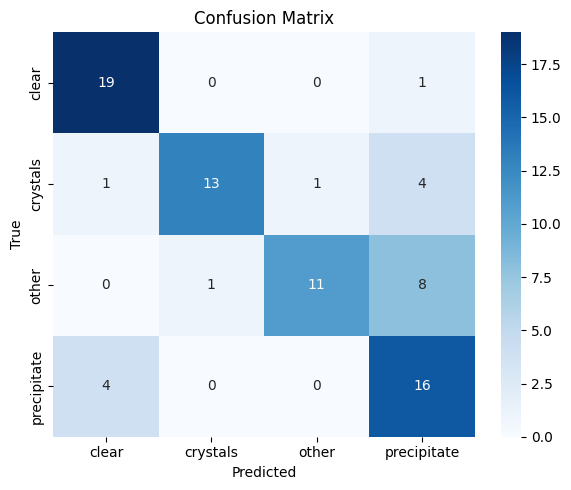

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract labels
y_true = df_merge['label_gt']
y_pred = df_merge['label_pred']

# Get unique sorted labels
labels = sorted(list(set(y_true) | set(y_pred)))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [52]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 🧮 Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2f}")

# 🧮 Precision, Recall, F1 (macro average)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Precision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1-score (macro): {f1:.2f}")

# 📄 Classification Report (per class)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels))


Accuracy: 0.75
Precision (macro): 0.80
Recall (macro): 0.75
F1-score (macro): 0.75

Classification Report:
              precision    recall  f1-score   support

       clear       0.79      0.95      0.86        20
    crystals       0.93      0.68      0.79        19
       other       0.92      0.55      0.69        20
 precipitate       0.55      0.80      0.65        20

    accuracy                           0.75        79
   macro avg       0.80      0.75      0.75        79
weighted avg       0.80      0.75      0.75        79

